<a id='title'></a>
#  Beyond the Lights: Charting Los Angeles' Entertainment Scene
- Los Angeles, a city of dreams, and entertainment. With the help of SeatGeek's API, we will take a deep dive into third-party ticketing data to better understand live events within Los Angeles. 
- We start with data gathering, leveraging the requests package to make proper API calls, and then Pandas, Numpy and others to extract, clean and refine our data before manipulating it further with advanced Excel functionality. 

### Quick links:
- [Jump to API Call](#API_Call)
- [Jump to Functions](#Functions)
- [Jump to Data Cleansing/Processing](#Cleaning_Extracting_Joining)
- [Jump to Evaluation and Refinement](#Evaluate)

In [1]:
# Relevant packages
# ------------------

# Connect to Website
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import requests 
import json

# data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

# miscellaneous
import ast
from tqdm import tqdm

# Stylistic setting preferences
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [12,5]
plt.style.use('bmh')

<a id='API_Call'></a>
# API request and local file saving ([top](#title))

In [2]:
# Connecting to the Web and setting up predefined parameters
# -----------------------------------------------------------------------

# Setting the API link to events within Los Angeles, at a range of a 12 mile radius
url = 'https://api.seatgeek.com/2/events?lat=34.052235&lon=-118.243683&range=12mi'

# Setting the parameters 
parameters = {
    'client_id': 'ID',
    'client_secret': 'secret'}

# Setting up headers
headers = {
    'Accept': 'application/vnd.api+json',
    'Content-Type': 'application/json'}

# Initialize a list to store all events data
events = []

# Creates a session, for pagination support (header overhead & limit rating)
session = Session()
session.headers.update(headers)

# Setting up total entries for a progress bar; pulling meta data from the first page shows how many entries are available
total_events = 2010

# Initialize tqdm progress bar
pbar = tqdm(total=total_events)

# Collect up to 2010 events according to meta data totals
for page in range(1, 203):
    updated_url = f"{url}&page={page}"
        
    try:
        response = session.get(updated_url, params=parameters)
        data = json.loads(response.text)
        
        # Append the events from the current page to all_events_data
        events.extend(data['events'])
        # updates progress bar for every 10 entries on a page
        pbar.update(10)              
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(f"Error on page {page}: {e}")

# Convert the collected data into a DataFrame
events = pd.DataFrame(events)

# Display the shape of the resulting DataFrame
events.shape

# Adapt the file of the name to save by the date the data was pulled
today = dt.today().strftime('%Y-%m-%d')
filename = f'seatgeekevents_{today}.csv'
filename_updated = filename.replace('-','_')

events.to_csv(f'G:PostgresSQL/Projects/Ticket_Analysis_Visual/{filename_updated}', index=False)

2020it [00:33, 69.13it/s]                          

<a id='Functions'></a>
# Functions to extract nested data ([top](#title))

In [3]:
def safe_literal_eval(s):
    """Attempt to evaluate a string as a Python literal; return original string if unsuccessful."""
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return s
    
def extracting_data(df,column,column_identifier):
    ''' Extracts data from a complex column, one with lists of dictionaries'''
    # Convert the string representation of lists/dicts to actual lists/dicts
    df[column] = df[column].apply(safe_literal_eval)
    
    # Create a DataFrame for extracted column
    extract_data = []
    for idx, row in df.iterrows():
        extract = row[column]
        if isinstance(extract, (list, dict)):
            for data in extract:
                data[column_identifier] = row[column_identifier]
                extract_data.append(data)
    extracted_df = pd.DataFrame(extract_data)

    return extracted_df

def extract_simple_data(df,column):
    ''' Extracts data from a simpler, flattened column (dictionary)'''
    # Convert the string representation of dictionaries in the 'stats' column to actual dictionaries
    df[column] = df[column].apply(safe_literal_eval)
    # Expand these dictionaries into separate columns
    extracted_simple_df = df[column].apply(pd.Series)
    
    return extracted_simple_df

<a id='Cleaning_Extracting_Joining'></a>
# Performing data extraction, refinement, and joining/concatenating ([top](#title))

In [4]:
events = pd.DataFrame()
events = pd.read_csv(f'G:PostgresSQL/Projects/Ticket_Analysis_Visual/{filename_updated}', index_col=False)
# events = pd.read_csv('G:PostgresSQL/Projects/Ticket_Analysis_Visual/seatgeekevents_2023_09_27.csv', index_col=False)

2020it [00:50, 69.13it/s]

In [5]:
# EXTRACTS PERFORMERS COLUMN, A LIST OF DICTIONARIES
performers_df = extracting_data(events,'performers','id')

# EXTRACTS GENRE COLUMN FROM THE PERFORMERS DATAFRAME, VERIFIES LIST OR DICTIONARY
genres_df = extracting_data(performers_df,'genres','id')

# EXTRACTS STATS COLUMN, FLATTENED DICTIONARY
sales_df = extract_simple_data(events,'stats')

# EXTRACTS VENUE COLUMN, FLATTENED DICTIONARY
venue_df = extract_simple_data(events,'venue')

# EXTRACTS VENUE COLUMN, FLATTENED DICTIONARY
sports_df = extracting_data(performers_df,'divisions','id')

In [6]:
display(performers_df.shape[0])
display(sports_df.shape[0])
display(venue_df.shape[0])
display(sales_df.shape[0])
display(events.shape[0])



display(performers_df.head(3))
display(sports_df.head(3))
display(venue_df.head(3))
display(sales_df.head(3))
display(events.head(3))

2860

1107

1977

1977

1977

,type,name,image,id,images,divisions,has_upcoming_events,primary,stats,taxonomies,image_attribution,url,score,slug,home_venue_id,short_name,num_upcoming_events,colors,image_license,genres,popularity,location,image_rights_message,home_team,away_team
0,band,Escape The Fate,https://seatgeek.com/images/performers-landsca...,6034984,{'huge': 'https://seatgeek.com/images/performe...,None,True,True,{'event_count': 8},"[{'id': 2000000, 'name': 'concerts', 'parent_i...",Chelsea Lauren / WireImage / Getty Images,https://seatgeek.com/escape-the-fate-tickets,0.52,escape-the-fate,NaN,Escape The Fate,8,None,rightsmanaged,"[{'id': 6034984, 'name': 'Pop', 'slug': 'pop',...",0,None,(c) Chelsea Lauren / WireImage / Getty Images,NaN,NaN
1,band,Point North,https://seatgeek.com/images/performers-landsca...,6034984,{'huge': 'https://seatgeek.com/images/performe...,None,True,NaN,{'event_count': 6},"[{'id': 2000000, 'name': 'concerts', 'parent_i...",https://www.flickr.com/photos/krists/355644397...,https://seatgeek.com/point-north-tickets,0.46,point-north,NaN,Point North,6,None,https://creativecommons.org/licenses/by/2.0/,NaN,0,None,[This image](https://www.flickr.com/photos/kri...,NaN,NaN
2,band,Stitched up Heart,https://seatgeek.com/images/performers-landsca...,6034984,{'huge': 'https://seatgeek.com/images/performe...,None,True,NaN,{'event_count': 6},"[{'id': 2000000, 'name': 'concerts', 'parent_i...",Mat Hayward / Getty Images Entertainment / Get...,https://seatgeek.com/stitched-up-heart-tickets,0.34,stitched-up-heart,NaN,Stitched up Heart,6,None,rightsmanaged,"[{'id': 6034984, 'name': 'Rock', 'slug': 'rock...",0,None,(c) Mat Hayward / Getty Images Entertainment /...,NaN,NaN


,taxonomy_id,short_name,display_name,display_type,division_level,slug,id
0,1050100,Western,Western Conference,Conference,1,western-conference,6073549
1,1020100,None,AFC,Conference,1,None,6019448
2,1020100,AFC West,AFC West,Division,2,afc-west,6019448


,state,name_v2,postal_code,name,links,timezone,url,score,location,address,country,has_upcoming_events,num_upcoming_events,city,slug,extended_address,id,popularity,access_method,metro_code,capacity,display_location
0,CA,The Belasco - Los Angeles,90015,The Belasco - Los Angeles,[],America/Los_Angeles,https://seatgeek.com/venues/the-belasco-los-an...,0.60,"{'lat': 34.0403, 'lon': -118.259}",1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,0,None,803,1000,"Los Angeles, CA"
1,CA,Moroccan Lounge,90012,Moroccan Lounge,[],America/Los_Angeles,https://seatgeek.com/venues/moroccan-lounge/ti...,0.51,"{'lat': 34.0487, 'lon': -118.234}",901 E 1st St,US,True,52,Los Angeles,moroccan-lounge,"Los Angeles, CA 90012",432202,0,None,803,0,"Los Angeles, CA"
2,CA,The Regent Theater,90013,The Regent Theater,[],America/Los_Angeles,https://seatgeek.com/venues/the-regent-theater...,0.57,"{'lat': 34.0471, 'lon': -118.248}",448 South Main Street,US,True,50,Los Angeles,the-regent-theater,"Los Angeles, CA 90013",56365,0,None,803,0,"Los Angeles, CA"


,listing_count,average_price,lowest_price_good_deals,lowest_price,highest_price,visible_listing_count,dq_bucket_counts,median_price,lowest_sg_base_price,lowest_sg_base_price_good_deals
0,1.0,38.0,NaN,38.0,38.0,1.0,"[0, 0, 1, 0, 0, 0, 0, 0]",38.0,23.0,NaN
1,4.0,47.0,NaN,36.0,65.0,4.0,"[0, 0, 0, 0, 0, 0, 0, 0]",40.0,21.0,NaN
2,1.0,33.0,NaN,33.0,33.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0]",33.0,19.0,NaN


,type,id,datetime_utc,venue,datetime_tbd,performers,is_open,links,datetime_local,time_tbd,short_title,visible_until_utc,stats,taxonomies,url,score,announce_date,created_at,date_tbd,title,popularity,description,status,access_method,event_promotion,announcements,conditional,enddatetime_utc,visible_at,is_visible_override,tdc_pvo_id,tdc_pv_id,is_visible,themes,domain_information,general_admission
0,concert,6034984,2023-09-28T01:00:00,"{'state': 'CA', 'name_v2': 'The Belasco - Los ...",False,"[{'type': 'band', 'name': 'Escape The Fate', '...",False,[],2023-09-27T18:00:00,False,"Escape the Fate with D.R.U.G.S., Point North, ...",2023-09-28T05:00:00,"{'listing_count': 1, 'average_price': 38, 'low...","[{'id': 2000000, 'name': 'concert', 'parent_id...",https://seatgeek.com/escape-the-fate-tickets/l...,0.264,2023-05-23T00:00:00,2023-05-23T17:36:29,False,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,NaN,normal,NaN,NaN,{},False,NaN,2023-05-23T17:36:28Z,UNSET,0,0,True,[],[],NaN
1,concert,6133968,2023-09-28T01:30:00,"{'state': 'CA', 'name_v2': 'Moroccan Lounge', ...",False,"[{'type': 'band', 'name': 'Coyote Island', 'im...",False,[],2023-09-27T18:30:00,False,Coyote Island,2023-09-28T05:30:00,"{'listing_count': 4, 'average_price': 47, 'low...","[{'id': 2000000, 'name': 'concert', 'parent_id...",https://seatgeek.com/coyote-island-tickets/los...,0.143,2023-08-19T00:00:00,2023-08-19T11:57:17,False,Coyote Island,0.602,NaN,normal,NaN,NaN,{},False,NaN,2023-08-19T13:33:28Z,UNSET,0,0,True,[],[],NaN
2,concert,6025585,2023-09-28T02:00:00,"{'state': 'CA', 'name_v2': 'The Regent Theater...",False,"[{'type': 'band', 'name': 'Matt Maeson', 'imag...",False,[],2023-09-27T19:00:00,False,Matt Maeson with Steinza,2023-09-28T06:00:00,"{'listing_count': 1, 'average_price': 33, 'low...","[{'id': 2000000, 'name': 'concert', 'parent_id...",https://seatgeek.com/matt-maeson-tickets/los-a...,0.216,2023-05-18T00:00:00,2023-05-18T15:02:57,False,Matt Maeson with Steinza,0.645,NaN,normal,NaN,NaN,{},False,NaN,2023-05-18T12:33:41Z,UNSET,0,0,True,[],[],True


In [7]:
display(events.columns)
display(performers_df.columns)
display(genres_df.columns)
display(sales_df.columns)
display(venue_df.columns)
display(sports_df.columns)

Index(['type', 'id', 'datetime_utc', 'venue', 'datetime_tbd', 'performers',
       'is_open', 'links', 'datetime_local', 'time_tbd', 'short_title',
       'visible_until_utc', 'stats', 'taxonomies', 'url', 'score',
       'announce_date', 'created_at', 'date_tbd', 'title', 'popularity',
       'description', 'status', 'access_method', 'event_promotion',
       'announcements', 'conditional', 'enddatetime_utc', 'visible_at',
       'is_visible_override', 'tdc_pvo_id', 'tdc_pv_id', 'is_visible',
       'themes', 'domain_information', 'general_admission'],
      dtype='object')

Index(['type', 'name', 'image', 'id', 'images', 'divisions',
       'has_upcoming_events', 'primary', 'stats', 'taxonomies',
       'image_attribution', 'url', 'score', 'slug', 'home_venue_id',
       'short_name', 'num_upcoming_events', 'colors', 'image_license',
       'genres', 'popularity', 'location', 'image_rights_message', 'home_team',
       'away_team'],
      dtype='object')

Index(['id', 'name', 'slug', 'primary', 'images', 'image', 'document_source'], dtype='object')

Index(['listing_count', 'average_price', 'lowest_price_good_deals',
       'lowest_price', 'highest_price', 'visible_listing_count',
       'dq_bucket_counts', 'median_price', 'lowest_sg_base_price',
       'lowest_sg_base_price_good_deals'],
      dtype='object')

Index(['state', 'name_v2', 'postal_code', 'name', 'links', 'timezone', 'url',
       'score', 'location', 'address', 'country', 'has_upcoming_events',
       'num_upcoming_events', 'city', 'slug', 'extended_address', 'id',
       'popularity', 'access_method', 'metro_code', 'capacity',
       'display_location'],
      dtype='object')

Index(['taxonomy_id', 'short_name', 'display_name', 'display_type',
       'division_level', 'slug', 'id'],
      dtype='object')

In [8]:
# making copies of the original dataframes for reference
master = events.copy()
master_sales = sales_df.copy()
master_venue = venue_df.copy()
master_performers = performers_df.copy()
master_sports = sports_df.copy()

# renaming columns to avoid column_x, column_y
genre = genres_df.rename(columns={'id':'experience_id'})
venue_df = venue_df.rename(columns={'id':'venue_id','score':'venue_score', 'name':'venue_name','slug':'venue_slug',
                                   'has_upcoming_events':'has_upcoming_venue_events'})
performers_df = performers_df.rename(columns={'slug':'performer_slug','num_upcoming_events':'upcoming_events_performer',
                                              'score':'performer_score','type':'performer_type','has_upcoming_events':'has_upcoming_performances'})
sports_df = sports_df.loc[~(pd.isna(sports_df['short_name'])) | (sports_df['short_name'] == 'None')]
sports_df = sports_df[~sports_df.duplicated()]
sports_df = sports_df.rename(columns={'taxonomy_id':'sports_id','short_name':'sports_short_name','display_name':'sports_disp_name',
                                     'display_type':'sports_disp_type','slug':'sports_slug','id':'event_id_sports'})


# removing any unnecessary or undefined columns (out of scope for project)
genre_df = genres_df.drop(columns=['images','image','document_source'],axis=1)
events = events.drop(columns=['datetime_tbd','venue', 'performers', 'stats', 'visible_until_utc', 'time_tbd','date_tbd','access_method', 
                              'datetime_utc', 'is_open', 'links', 'time_tbd', 'url','created_at', 'description', 'status',
                              'event_promotion','announcements', 'conditional', 'enddatetime_utc','visible_at','is_visible_override',
                              'tdc_pvo_id','tdc_pv_id','is_visible','themes','domain_information','taxonomies'], axis=1)
sales_df = sales_df.drop(columns=['lowest_price_good_deals','dq_bucket_counts','lowest_sg_base_price',
                                  'visible_listing_count','lowest_sg_base_price_good_deals'], axis=1)
venue_df = venue_df.drop(columns=['name_v2','links','url','popularity','access_method','metro_code'], axis=1)
performers_df = performers_df.drop(columns=['image_rights_message','image_license','genres','image_attribution',
                                           'url','taxonomies','images','image','popularity','location',
                                           'divisions','stats'], axis=1)

In [9]:
# Evidence of multiple performers per event, to be merged with events last as it will expand the entries within events
performers_df.groupby(by='id').size().sort_values(ascending=False).head(660)

id
5953962    54
6141055    16
6117234     8
5404326     8
5926994     8
           ..
6202847     1
6118613     1
6202606     1
6177582     1
6202570     1
Length: 660, dtype: int64

In [10]:
# Creating a genre_list 
genre_list = ['alternative', 'classic-rock', 'pop', 'rock', 'hard-rock', 'blues',
       'hip-hop', 'rap', 'indie', 'jazz', 'country_music', 'folk', 'electronic',
       'techno', 'punk', 'reggae', 'rnb', 'soul', 'latin', 'classical']

# Using one-hot encoding to create columns by genre, renaming then grouping by performer 
genre_dummies = pd.get_dummies(genres_df['slug'])
genre_dummies = genre_dummies.rename(columns={'country':'country_music'})
genre_dummies['performer_id'] = genre['experience_id']
genre_dummies = genre_dummies.groupby('performer_id').max().reset_index()

# merging dummies with performer dataframe based on the event id
performers_df = performers_df.merge(genre_dummies, left_on='id', right_on='performer_id', how='left')
performers_df = performers_df.drop('performer_id',axis=1)
performers_df = performers_df.rename(columns={'id':'experience_id'})

# Filling out any events that are not performers (musical) with proper values for genre
for item in genre_list:
    performers_df[item] = performers_df[item].fillna(0).astype(float)
    performers_df[item] = performers_df[item].astype(int)

In [12]:
# Important note: only run this cell once to avoid adding duplicated columns

# Concatenating sales data and venue data to events
updated_events = pd.concat([events,sales_df], axis=1)
updated_events = pd.concat([updated_events,venue_df], axis=1)

# Merging sports with updated_events for additional sports data
updated_events = updated_events.merge(sports_df,left_on='id',right_on='event_id_sports',how='left')

# Merging performers data to events data, saving it locally to seatgeekevents_full
seatgeek_events = updated_events.merge(performers_df, left_on='id', right_on='experience_id', how='inner')
seatgeek_events.to_csv('G:PostgresSQL/Projects/Ticket_Analysis_Visual/seatgeekevents_full.csv', index=False)

<a id='Evaluate'></a>
# Evaluate and Refine data ([top](#title))

In [65]:
seatgeek_events = pd.read_csv('G:PostgresSQL/Projects/Ticket_Analysis_Visual/seatgeekevents_full.csv', index_col=False)

#### .info, .describe()

In [66]:
# df.shape and df.info()
display(seatgeek_events.shape)
seatgeek_events.info()

# making copy of seatgeek_events
master_seatgeekdata = pd.read_csv('G:PostgresSQL/Projects/Ticket_Analysis_Visual/seatgeekevents_full.csv', index_col=False)
seatgeek_events = master_seatgeekdata.copy()
seatgeek_events.head(5)

(3239, 70)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   type                       3239 non-null   object 
 1   id                         3239 non-null   int64  
 2   datetime_local             3239 non-null   object 
 3   short_title                3239 non-null   object 
 4   score                      3239 non-null   float64
 5   announce_date              3239 non-null   object 
 6   title                      3239 non-null   object 
 7   popularity                 3239 non-null   float64
 8   general_admission          288 non-null    object 
 9   listing_count              3009 non-null   float64
 10  average_price              3009 non-null   float64
 11  lowest_price               3009 non-null   float64
 12  highest_price              3009 non-null   float64
 13  median_price               3009 non-null   float

,type,id,datetime_local,short_title,score,announce_date,title,popularity,general_admission,listing_count,average_price,lowest_price,highest_price,median_price,state,postal_code,venue_name,timezone,venue_score,location,address,country,has_upcoming_venue_events,num_upcoming_events,city,venue_slug,extended_address,venue_id,capacity,display_location,sports_id,sports_short_name,sports_disp_name,sports_disp_type,division_level,sports_slug,event_id_sports,performer_type,name,experience_id,has_upcoming_performances,primary,performer_score,performer_slug,home_venue_id,short_name,upcoming_events_performer,colors,home_team,away_team,alternative,blues,classic-rock,classical,country_music,electronic,folk,hard-rock,hip-hop,indie,jazz,latin,pop,punk,rap,reggae,rnb,rock,soul,techno
0,concert,6034984,2023-09-27T18:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23T00:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,NaN,1.0,38.0,38.0,38.0,38.0,CA,90015.0,The Belasco - Los Angeles,America/Los_Angeles,0.6,"{'lat': 34.0403, 'lon': -118.259}",1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,band,Escape The Fate,6034984,True,True,0.52,escape-the-fate,NaN,Escape The Fate,8,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
1,concert,6034984,2023-09-27T18:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23T00:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,NaN,1.0,38.0,38.0,38.0,38.0,CA,90015.0,The Belasco - Los Angeles,America/Los_Angeles,0.6,"{'lat': 34.0403, 'lon': -118.259}",1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,band,Point North,6034984,True,NaN,0.46,point-north,NaN,Point North,6,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
2,concert,6034984,2023-09-27T18:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23T00:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,NaN,1.0,38.0,38.0,38.0,38.0,CA,90015.0,The Belasco - Los Angeles,America/Los_Angeles,0.6,"{'lat': 34.0403, 'lon': -118.259}",1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,band,Stitched up Heart,6034984,True,NaN,0.34,stitched-up-heart,NaN,Stitched up Heart,6,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
3,concert,6034984,2023-09-27T18:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23T00:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,NaN,1.0,38.0,38.0,38.0,38.0,CA,90015.0,The Belasco - Los Angeles,America/Los_Angeles,0.6,"{'lat': 34.0403, 'lon': -118.259}",1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,band,Destroy Rebuild Until God Shows,6034984,True,NaN,0.34,destroy-rebuild-until-god-shows,NaN,Destroy Rebuild Until God Shows,6,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0
4,concert,6034984,2023-09-27T18:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23T00:00:00,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,NaN,1.0,38.0,38.0,38.0,38.0,CA,90015.0,The Belasco - Los Angeles,America/Los_Angeles,0.6,"{'lat': 34.0403, 'lon': -118.259}",1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,band,D.R.U.G.S.,6034984,True,NaN,0.34,d-r-u-g-s,NaN,D.R.U.G.S.,6,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0


In [67]:
seatgeek_events.describe(include='all')

,type,id,datetime_local,short_title,score,announce_date,title,popularity,general_admission,listing_count,average_price,lowest_price,highest_price,median_price,state,postal_code,venue_name,timezone,venue_score,location,address,country,has_upcoming_venue_events,num_upcoming_events,city,venue_slug,extended_address,venue_id,capacity,display_location,sports_id,sports_short_name,sports_disp_name,sports_disp_type,division_level,sports_slug,event_id_sports,performer_type,name,experience_id,has_upcoming_performances,primary,performer_score,performer_slug,home_venue_id,short_name,upcoming_events_performer,colors,home_team,away_team,alternative,blues,classic-rock,classical,country_music,electronic,folk,hard-rock,hip-hop,indie,jazz,latin,pop,punk,rap,reggae,rnb,rock,soul,techno
count,3239,3.239000e+03,3239,3239,3239.000000,3239,3239,3239.000000,288,3009.000000,3009.000000,3009.000000,3009.000000,3009.000000,3239,3225.000000,3239,3239,3239.00000,3239,3239,3239,3239,3239.000000,3239,3239,3239,3239.000000,3239.000000,3239,9.670000e+02,967,967,967,967.000000,967,9.670000e+02,3239,3239,3.239000e+03,3239,2167,3239.000000,3239,934.000000,3239,3239.000000,860,553,553,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000
unique,29,NaN,1122,1334,NaN,198,1335,NaN,1,NaN,NaN,NaN,NaN,NaN,1,NaN,88,1,NaN,86,86,1,1,NaN,9,88,40,NaN,NaN,9,NaN,34,34,2,NaN,34,NaN,35,1654,NaN,1,1,NaN,1655,NaN,1649,NaN,121,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,concert,NaN,2023-12-02T11:00:00,Los Angeles Philharmonic - Los Angeles,NaN,2023-07-27T00:00:00,Los Angeles Philharmonic - Los Angeles,NaN,True,NaN,NaN,NaN,NaN,NaN,CA,NaN,Crypto.com Arena,America/Los_Angeles,NaN,"{'lat': 34.043, 'lon': -118.267}",1111 South Figueroa Street,US,True,NaN,Los Angeles,crypto-com-arena,"Los Angeles, CA 90015",NaN,NaN,"Los Angeles, CA",NaN,Pacific,Western - Pacific,Division,NaN,western-pacific,NaN,band,Los Angeles Dodgers,NaN,True,True,NaN,los-angeles-dodgers,NaN,Dodgers,NaN,"{'all': ['#005A9C', '#B0B7BC', '#005A9C'], 'ic...",True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1401,NaN,55,89,NaN,308,89,NaN,288,NaN,NaN,NaN,NaN,NaN,3239,NaN,506,3239,NaN,506,506,3239,3239,NaN,2777,506,749,NaN,NaN,2777,NaN,258,258,805,NaN,258,NaN,1495,146,NaN,3239,2167,NaN,146,NaN,146,NaN,146,553,553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.079682e+06,NaN,NaN,0.271601,NaN,NaN,0.579841,NaN,297.019608,559.500499,108.101030,7718.625789,228.303091,NaN,90070.036589,NaN,NaN,0.71691,NaN,NaN,NaN,NaN,83.027169,NaN,NaN,NaN,76489.523618,13025.517135,NaN,1.025071e+06,NaN,NaN,NaN,1.975181,NaN,6.101466e+06,NaN,NaN,6.079682e+06,NaN,NaN,0.511522,NaN,54125.426124,NaN,63.669960,NaN,NaN,NaN,0.157147,0.018215,0.021920,0.000926,0.041680,0.066996,0.050324,0.063909,0.013276,0.045384,0.016672,0.037048,0.219512,0.047854,0.044149,0.001235,0.025625,0.215807,0.025316,0.025316
std,NaN,8.336680e+04,NaN,NaN,0.193874,NaN,NaN,0.164887,NaN,550.030692,6083.016318,116.860069,24175.336821,378.743366,NaN,170.739004,NaN,NaN,0.17449,NaN,NaN,NaN,NaN,72.960018,NaN,NaN,NaN,164617.007318,20878.593023,NaN,1.149843e+04,NaN,NaN,NaN,0.155654,NaN,4.099130e+04,NaN,NaN,8.336680e+04,NaN,NaN,0.163032,NaN,145916.550235,NaN,94.500753,NaN,NaN,NaN,0.363996,0.133751,0.146446,0.030424,0.199887,0.250054,0.218647,0.244628,0.114471,0.208178,0.128058,0.188910,0.413980,0.213491,0.205459,0.035126,0.158039,0.411445,0.157109,0.157109
min,NaN,5.126371e+06,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,1.000000,29.000000,9.000000,29.000000,25.000000,NaN,90005.000000,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,1.010100e+06,NaN,NaN,NaN,1.000000,NaN,5.901051e+06,NaN,NaN,5.126371e+06,NaN,NaN,0.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,0.0000

#### Missing values (columns)

In [68]:
# shortened view of the columns with missing data for further investigation
seatgeek_events.isnull().sum().sort_values(ascending=False).head(20)

general_admission    2951
away_team            2686
home_team            2686
colors               2379
home_venue_id        2305
sports_slug          2272
event_id_sports      2272
division_level       2272
sports_disp_type     2272
sports_disp_name     2272
sports_short_name    2272
sports_id            2272
primary              1072
median_price          230
highest_price         230
listing_count         230
average_price         230
lowest_price          230
postal_code            14
performer_slug          0
dtype: int64

In [69]:
# Split date and time of events, convert to datetime types , only run once
seatgeek_events['event_showtime'] = pd.to_datetime(seatgeek_events['datetime_local'].str[11:], format="%H:%M:%S").dt.time
seatgeek_events = seatgeek_events.rename(columns={'datetime_local':'date_showtime'})
seatgeek_events['date_showtime'] = pd.to_datetime(seatgeek_events['date_showtime'].str[:10], format="%Y-%m-%d")

In [70]:
# Convert 'primary' to binary
seatgeek_events['primary'] = np.where(seatgeek_events['primary'] == True, 1, 0)

# Convert 'general_admission' to binary
seatgeek_events['general_admission'] = np.where(seatgeek_events['general_admission'] == True, 1, 0)

# Convert 'away_team' to binary
seatgeek_events['away_team'] = np.where(seatgeek_events['away_team'] == True, 1, 0)

# Convert 'home_team' to binary
seatgeek_events['home_team'] = np.where(seatgeek_events['home_team'] == True, 1, 0)

# Fill in non sport events with 0
seatgeek_events['sports_id'] = seatgeek_events['sports_id'].fillna(0)

# Fill in non sport events with string identifier
seatgeek_events['sports_short_name'] = seatgeek_events['sports_short_name'].fillna('Not a Sport')

# Fill in non sport events with string identifier
seatgeek_events['sports_disp_type'] = seatgeek_events['sports_disp_type'].fillna('Not a Sport')

# Fill in non sport events with string identifier
seatgeek_events['sports_disp_name'] = seatgeek_events['sports_disp_name'].fillna('No Division')

# Fill in state locations with 'CA' given the data is focused in the Los Angeles area
seatgeek_events['state'] = seatgeek_events['state'].fillna('CA')
seatgeek_events['country'] = seatgeek_events['country'].fillna('US')

# Fill in non sport events with 0
seatgeek_events['division_level'] = seatgeek_events['division_level'].fillna(0)

# Fill in non sport events with string identifier
seatgeek_events['sports_slug'] = seatgeek_events['sports_slug'].fillna('not-a-sport')

# Fill any empty postal_codes with 0, temporarily until confirming no other postcal code available
seatgeek_events['postal_code'] = seatgeek_events['postal_code'].fillna(0).astype(int)

# Fill any empty home_venue_id with 0, to represent no information
seatgeek_events['home_venue_id'] = seatgeek_events['home_venue_id'].fillna(0).astype(int)

# Dropping any columns after refinement
seatgeek_events = seatgeek_events.drop(columns=['colors','experience_id', 'timezone', 'event_id_sports'], axis=1)

# Renaming for better readibility
seatgeek_events = seatgeek_events.rename({'display_location':'State', 'num_upcoming_events': 'upcoming_events_venue'})

# Altering the display_location to state by only taking the 2 character code in the same field
seatgeek_events['state'] = seatgeek_events['state'].str[-2:]

# renaming a name column to a more meaningful name
seatgeek_events = seatgeek_events.rename(columns={'name':'performer_name'})

# Fixing the venue name for one specifically
mask = seatgeek_events['venue_name'].str.contains('516')
seatgeek_events.loc[mask,'venue_name'] = 'The Lucha Underground Arena'
seatgeek_events.loc[mask,'venue_slug'] = 'the-lucha-underground-arena'

# Validating that these rows are no longer empty
seatgeek_events[['general_admission','away_team','home_team']].isnull().sum()

general_admission    0
away_team            0
home_team            0
dtype: int64

In [71]:
# Filtering empty values for subset with same missing value totals.
seatgeek_events[seatgeek_events[['median_price','highest_price','lowest_price','average_price','listing_count']].isnull()]

# Observing events that are dated to premier beyond 2030, and therefore have no price data. Removed from set. 
seatgeek_events[(seatgeek_events['median_price'].isnull()) & (seatgeek_events['date_showtime']>"2030-01-01")]
seatgeek_events = seatgeek_events[~((seatgeek_events['median_price'].isnull()) & (seatgeek_events['date_showtime']>"2030-01-01"))]
seatgeek_events['announce_date'] = pd.to_datetime(seatgeek_events['announce_date'].str[:10], format="%Y-%m-%d")

#### Removing duplicated rows across entire dataset

In [72]:
# Duplicated rows (all columns), removing them
seatgeek_events[seatgeek_events.duplicated()].count()
seatgeek_events = seatgeek_events[~(seatgeek_events.duplicated())]

In [73]:
seatgeek_events.isnull().sum().sort_values(ascending=False).head(20)

average_price                216
lowest_price                 216
median_price                 216
highest_price                216
listing_count                216
classical                      0
classic-rock                   0
blues                          0
alternative                    0
away_team                      0
type                           0
electronic                     0
home_team                      0
upcoming_events_performer      0
short_name                     0
home_venue_id                  0
performer_slug                 0
performer_score                0
primary                        0
country_music                  0
dtype: int64

#### Engineering features based on existing data for filtering and grouping

In [74]:
# a flag to filter for sport events
seatgeek_events['is_a_sport'] = (seatgeek_events['sports_id'] > 0).astype(int)

# flagging events beyond current year with no price data (assuming average_price)
future_mask = (seatgeek_events['average_price'].isna()) & (seatgeek_events['date_showtime'].dt.year > (dt.now().year))
no_prices_available = seatgeek_events['average_price'].isna()
seatgeek_events['future_event_TBD'] = future_mask.astype(int)
seatgeek_events['missing_price'] = no_prices_available.astype(int)

# extracting longitude and latitude from location, and dropping the location column
seatgeek_events['latitude'] = seatgeek_events['location'].str[8:14]
seatgeek_events['longitude'] = seatgeek_events['location'].str[24:-1] 
seatgeek_events = seatgeek_events.drop(columns=['location'],axis=1)

In [75]:
seatgeek_events[seatgeek_events['average_price'].isnull()]

,type,id,date_showtime,short_title,score,announce_date,title,popularity,general_admission,listing_count,average_price,lowest_price,highest_price,median_price,state,postal_code,venue_name,venue_score,address,country,has_upcoming_venue_events,num_upcoming_events,city,venue_slug,extended_address,venue_id,capacity,display_location,sports_id,sports_short_name,sports_disp_name,sports_disp_type,division_level,sports_slug,performer_type,name,has_upcoming_performances,primary,performer_score,performer_slug,home_venue_id,short_name,upcoming_events_performer,home_team,away_team,alternative,blues,classic-rock,classical,country_music,electronic,folk,hard-rock,hip-hop,indie,jazz,latin,pop,punk,rap,reggae,rnb,rock,soul,techno,event_showtime,is_a_sport,future_event_TBD,missing_price,latitude,longitude
12,concert,6067984,2023-09-27,Uada with Cloak and Ghost Bath,0.221,2023-06-22,Uada with Cloak and Ghost Bath,0.618,1,NaN,NaN,NaN,NaN,NaN,CA,90036,El Rey Theatre,0.58,5515 Wilshire Boulevard,US,True,34,Los Angeles,el-rey-theatre-1,"Los Angeles, CA 90036",959,771,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Uada,True,1,0.19,uada,0,Uada,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,19:00:00,0,0,1,34.062,-118.349
13,concert,6067984,2023-09-27,Uada with Cloak and Ghost Bath,0.221,2023-06-22,Uada with Cloak and Ghost Bath,0.618,1,NaN,NaN,NaN,NaN,NaN,CA,90036,El Rey Theatre,0.58,5515 Wilshire Boulevard,US,True,34,Los Angeles,el-rey-theatre-1,"Los Angeles, CA 90036",959,771,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Ghost Bath,True,0,0.20,ghost-bath,0,Ghost Bath,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,19:00:00,0,0,1,34.062,-118.349
14,concert,6067984,2023-09-27,Uada with Cloak and Ghost Bath,0.221,2023-06-22,Uada with Cloak and Ghost Bath,0.618,1,NaN,NaN,NaN,NaN,NaN,CA,90036,El Rey Theatre,0.58,5515 Wilshire Boulevard,US,True,34,Los Angeles,el-rey-theatre-1,"Los Angeles, CA 90036",959,771,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Cloak,True,0,0.19,cloak,0,Cloak,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,19:00:00,0,0,1,34.062,-118.349
15,concert,6168596,2023-09-27,Mark Ronson,0.264,2023-09-07,Mark Ronson,0.642,0,NaN,NaN,NaN,NaN,NaN,CA,90015,The GRAMMY Museum,0.43,800 West Olympic Boulevard,US,True,10,Los Angeles,the-grammy-museum,"Los Angeles, CA 90015",1862,0,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Mark Ronson,True,1,0.24,mark-ronson,0,Mark Ronson,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,19:30:00,0,0,1,34.052,-118.244
24,concert,6143168,2023-09-27,Jai Paul,0.329,2023-08-21,Jai Paul,0.695,0,NaN,NaN,NaN,NaN,NaN,CA,90015,The Mayan,0.36,1038 South Hill Street,US,True,1,Los Angeles,the-mayan,"Los Angeles, CA 90015",3520,0,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Jai Paul,True,1,0.66,jai-paul,0,Jai Paul,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21:00:00,0,0,1,34.040,-118.259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,broadway_tickets_national,5956183,2024-07-14,Peter Pan - Los Angeles,0.000,2023-02-25,Peter Pan - Los Angeles,0.239,0,NaN,NaN,NaN,NaN,NaN,CA,90028,Hollywood Pantages Theatre,0.73,6233 Hollywood Blvd.,US,True,263,Los Angeles,hollywood-pantages-theatre,"Los Angeles, CA 90028",1725,2703,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,theater,Peter Pan - Theatrical Production,True,1,0.37,peter-pan-theatrical-production,0,Peter Pan - Theatrical Production,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18:30:00,0,1,1,34.101,-118.325
3092,broadway_tickets_national,5956231,2024-08-04,Company - Los Angeles,0.000,2023-02-25,Company - Los Angeles,0.201,0,NaN,NaN,NaN,NaN,NaN,CA,90028,Holly

#### Finding the venues with no capacity information, and storing a venue df for dictionary reference

In [86]:
seatgeek_events[(seatgeek_events['venue_name']!="")&(seatgeek_events['capacity']==0)]['venue_name'].unique()

array(['Moroccan Lounge', 'The Regent Theater', 'Alex Theatre',
       'The GRAMMY Museum', 'The Bellwether', 'The Fonda Theatre',
       'The Mayan', 'Wallis Annenberg Stadium', 'The Peppermint Club',
       'Hollywood Palladium', 'YouTube Theater', 'Ford Amphitheatre',
       'The Wiltern', 'Pauley Pavilion', 'The Torch at LA Coliseum',
       'Galen Center', 'Orpheum Theatre - Los Angeles', 'Kia Forum',
       'Academy Nightclub', 'Los Angeles Center Studios',
       'Hollywood Bowl', 'The Ford - Los Angeles',
       'Knitting Factory Los Angeles', 'Campbell Hall',
       'Ahmanson Theatre', 'McAlister Field - USC',
       'Ukrainian Cultural Center', 'Gin Ling Way',
       'Los Angeles Memorial Coliseum', '1720',
       'Luckman Fine Arts Complex', 'Lodge Room', 'Gold Diggers',
       'San Gabriel Mission Playhouse', 'Zebulon', '1756 Naud Street',
       'Sullivan Field Loyola Marymount', 'Ricardo Montalban Theatre',
       'Highland Park Ebell Club', 'Globe Theatre Los Angeles',
 

In [92]:
# Taking the names from the filtered table, and manually inputting capacities found online
empty_capacity_venues = ['Moroccan Lounge', 'The Regent Theater', 'Alex Theatre','The GRAMMY Museum', 'The Bellwether', 
                         'The Fonda Theatre','The Mayan', 'Wallis Annenberg Stadium', 'The Peppermint Club',
                         'Hollywood Palladium', 'YouTube Theater', 'Ford Amphitheatre','The Wiltern', 'Pauley Pavilion',
                         'The Torch at LA Coliseum','Galen Center', 'Orpheum Theatre - Los Angeles', 'Kia Forum',
                         'Academy Nightclub', 'Los Angeles Center Studios','Hollywood Bowl', 'The Ford - Los Angeles',
                         'Knitting Factory Los Angeles', 'Campbell Hall','Ahmanson Theatre', 'McAlister Field - USC',
                         'Ukrainian Cultural Center', 'Gin Ling Way','Los Angeles Memorial Coliseum', '1720',
                         'Luckman Fine Arts Complex', 'Lodge Room', 'Gold Diggers','San Gabriel Mission Playhouse', 'Zebulon', '1756 Naud Street',
                         'Sullivan Field Loyola Marymount', 'Ricardo Montalban Theatre','Highland Park Ebell Club', 
                         'Globe Theatre Los Angeles','The Majestic Downtown + The Reserve', 'Royce Hall - UCLA',
                         'Catalina Bar & Grill', 'The Bourbon Room - Los Angeles','Japan America Theatre', 
                         'UCLA Health Training Center','Los Angeles Grand Park', 'Factory 93', 'Genghis Cohen',
                         'The Vermont Hollywood', 'The Lucha Underground Arena','Shrine LA Outdoors', 'Hollywood Christmas Parade',
                         'Barnes & Noble', 'Wilshire Ebell Theatre']

venue_capacities = {}

for venue in empty_capacity_venues:
    capacity = input(f"Enter capacity for {venue}: ")
    venue_capacities[venue] = capacity

venue_capacities_df = pd.DataFrame(list(venue_capacities.items()),columns=['Venue','Capacity'])

# Saving venue capacities locally
venue_capacities_df.to_csv(f"G:PostgresSQL/Projects/Ticket_Analysis_Visual/venue_capacities.csv", index=False)

venue_capacities_df

Enter capacity for Moroccan Lounge: 300
Enter capacity for The Regent Theater: 1100
Enter capacity for Alex Theatre: 1400
Enter capacity for The GRAMMY Museum: 200
Enter capacity for The Bellwether: 1500
Enter capacity for The Fonda Theatre: 1200
Enter capacity for The Mayan: 1700
Enter capacity for Wallis Annenberg Stadium: 2145
Enter capacity for The Peppermint Club: 250
Enter capacity for Hollywood Palladium: 4000
Enter capacity for YouTube Theater: 6000
Enter capacity for Ford Amphitheatre: 1200
Enter capacity for The Wiltern: 4000
Enter capacity for Pauley Pavilion: 13800
Enter capacity for The Torch at LA Coliseum: 10000
Enter capacity for Galen Center: 10258
Enter capacity for Orpheum Theatre - Los Angeles: 1976
Enter capacity for Kia Forum: 17500
Enter capacity for Academy Nightclub: 1500
Enter capacity for Los Angeles Center Studios: 400
Enter capacity for Hollywood Bowl: 17500
Enter capacity for The Ford - Los Angeles: 1200
Enter capacity for Knitting Factory Los Angeles: 300

In [128]:
# Compiling more information about venues from the seatgeek_events dataframe along with updated capacity values. 
venue_information = seatgeek_events[['venue_name','venue_score','address','country','state','city','postal_code','venue_id']]
venue_capacities_df = pd.merge(venue_capacities_df,venue_information, left_on='Venue', right_on='venue_name',how='left')
venue_capacities_df = venue_capacities_df[~(venue_capacities_df.duplicated())].reset_index()

In [130]:
# Create a mapping from venue names to capacities
capacity_mapping = venue_capacities_df.set_index('Venue')['Capacity']

# Replace capacity values in seatgeek_events where capacity is 0
mask = (seatgeek_events['capacity'] == 0)
seatgeek_events.loc[mask, 'capacity'] = seatgeek_events.loc[mask, 'venue_name'].map(capacity_mapping)

# validating that there are no longer empty capacity values
seatgeek_events[seatgeek_events['capacity']==0]

In [133]:
seatgeek_events.head(10)

,type,id,date_showtime,short_title,score,announce_date,title,popularity,general_admission,listing_count,average_price,lowest_price,highest_price,median_price,state,postal_code,venue_name,venue_score,address,country,has_upcoming_venue_events,num_upcoming_events,city,venue_slug,extended_address,venue_id,capacity,display_location,sports_id,sports_short_name,sports_disp_name,sports_disp_type,division_level,sports_slug,performer_type,performer_name,has_upcoming_performances,primary,performer_score,performer_slug,home_venue_id,short_name,upcoming_events_performer,home_team,away_team,alternative,blues,classic-rock,classical,country_music,electronic,folk,hard-rock,hip-hop,indie,jazz,latin,pop,punk,rap,reggae,rnb,rock,soul,techno,event_showtime,is_a_sport,future_event_TBD,missing_price,latitude,longitude
0,concert,6034984,2023-09-27,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,0,1.0,38.0,38.0,38.0,38.0,CA,90015,The Belasco - Los Angeles,0.60,1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Escape The Fate,True,1,0.52,escape-the-fate,0,Escape The Fate,8,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,18:00:00,0,0,0,34.040,-118.259
1,concert,6034984,2023-09-27,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,0,1.0,38.0,38.0,38.0,38.0,CA,90015,The Belasco - Los Angeles,0.60,1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Point North,True,0,0.46,point-north,0,Point North,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,18:00:00,0,0,0,34.040,-118.259
2,concert,6034984,2023-09-27,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,0,1.0,38.0,38.0,38.0,38.0,CA,90015,The Belasco - Los Angeles,0.60,1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Stitched up Heart,True,0,0.34,stitched-up-heart,0,Stitched up Heart,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,18:00:00,0,0,0,34.040,-118.259
3,concert,6034984,2023-09-27,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,0,1.0,38.0,38.0,38.0,38.0,CA,90015,The Belasco - Los Angeles,0.60,1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,Destroy Rebuild Until God Shows,True,0,0.34,destroy-rebuild-until-god-shows,0,Destroy Rebuild Until God Shows,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,18:00:00,0,0,0,34.040,-118.259
4,concert,6034984,2023-09-27,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,0,1.0,38.0,38.0,38.0,38.0,CA,90015,The Belasco - Los Angeles,0.60,1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,D.R.U.G.S.,True,0,0.34,d-r-u-g-s,0,D.R.U.G.S.,6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,18:00:00,0,0,0,34.040,-118.259
5,concert,6034984,2023-09-27,"Escape the Fate with D.R.U.G.S., Point North, ...",0.264,2023-05-23,"Escape the Fate with D.R.U.G.S., Point North, ...",0.676,0,1.0,38.0,38.0,38.0,38.0,CA,90015,The Belasco - Los Angeles,0.60,1050 South Hill Street,US,True,49,Los Angeles,the-belasco-los-angeles,"Los Angeles, CA 90015",30920,1000,"Los Angeles, CA",0.0,Not a Sport,No Division,Not a Sport,0.0,not-a-sport,band,GARZI,True,0,0.34,garzi,0,GARZI,6,0,

In [176]:
seatgeek_events.index = seatgeek_events['date_showtime']
seatgeek_events.index = pd.to_datetime(seatgeek_events.index)

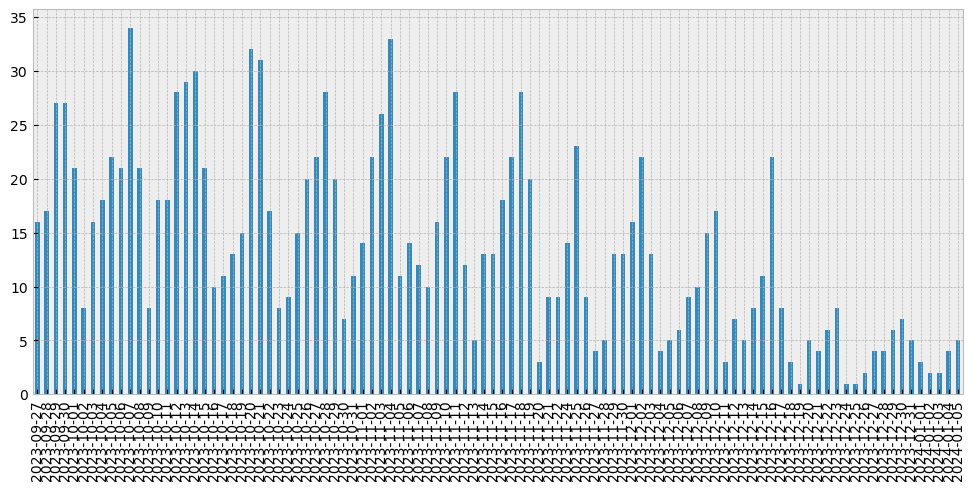

In [170]:
# Looking at unique events by creating a copy and removing duplicated id's. next 100 days with events
seatgeek_events_copy = seatgeek_events.copy()
seatgeek_events_copy.drop_duplicates(subset='id', keep='first', inplace=True)
seatgeek_events_copy.groupby(seatgeek_events_copy.index.date)['id'].count().head(100).plot(kind='bar');

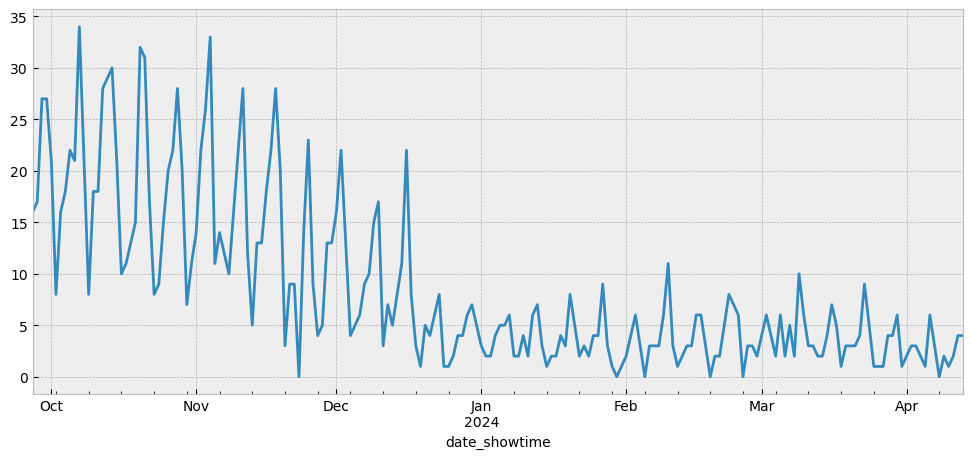

In [183]:
# Looking at events for entire dataset, plot is for the next 100 days, compared to the previous which is 100 days w/events.
seatgeek_events_copy['id'].resample('D').count().head(200).plot();

In [178]:
seatgeek_events_copy.shape

(1967, 71)

In [182]:
# Saving a copy locally
seatgeek_events.to_csv('seatgeekevents_full_updated.csv', index=False)

In [127]:
# Saving venue capacities locally
venue_capacities_df.to_csv(f"G:venue_capacities.csv", index=False)